# Traducción neuronal automática

Bienvenido a tu primera tarea de programación de esta semana. 

* Construirás un modelo de Traducción Neuronal Automática (NMT) para traducir fechas legibles por humanos ("25 de junio de 2009") a fechas legibles por máquinas ("2009-06-25"). 
* Lo harás utilizando un modelo de atención, uno de los más sofisticados modelos de secuencia a secuencia. 

Este cuaderno ha sido realizado en colaboración con el Deep Learning Institute de NVIDIA. 

## Nota importante sobre el envío al AutoGrader

Antes de enviar su tarea al AutoGrader, por favor asegúrese de que no está haciendo lo siguiente:

1. No ha añadido ninguna declaración _extra_ `print` en la tarea.
2. No ha añadido ninguna celda de código _extra_ en la tarea.
3. No ha cambiado ningún parámetro de la función.
4. No ha utilizado ninguna variable global dentro de sus ejercicios calificados. A menos que se le indique específicamente que lo haga, por favor absténgase de hacerlo y utilice las variables locales en su lugar.
5. No está cambiando el código de asignación donde no es necesario, como la creación de variables _extra_.

Si hace algo de lo siguiente, obtendrá un error como `Grader no encontrado` (o similarmente inesperado) al enviar su tarea. Antes de pedir ayuda/depurar los errores de su tarea, compruebe esto primero. Si este es el caso, y no recuerda los cambios que ha realizado, puede obtener una nueva copia de la tarea siguiendo estas [instrucciones](https://www.coursera.org/learn/nlp-sequence-models/supplement/qHIve/h-ow-to-refresh-your-workspace).



<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

# Neural Machine Translation

Welcome to your first programming assignment for this week! 

* You will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). 
* You will do this using an attention model, one of the most sophisticated sequence-to-sequence models. 

This notebook was produced together with NVIDIA's Deep Learning Institute. 

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/nlp-sequence-models/supplement/qHIve/h-ow-to-refresh-your-workspace).

## Table of Contents

- [Packages](#0)
- [1 - Translating Human Readable Dates Into Machine Readable Dates](#1)
    - [1.1 - Dataset](#1-1)
- [2 - Neural Machine Translation with Attention](#2)
    - [2.1 - Attention Mechanism](#2-1)
        - [Exercise 1 - one_step_attention](#ex-1)
        - [Exercise 2 - modelf](#ex-2)
        - [Exercise 3 - Compile the Model](#ex-3)
- [3 - Visualizing Attention (Optional / Ungraded)](#3)
    - [3.1 - Getting the Attention Weights From the Network](#3-1)

<a name='0'></a>
## Packages

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

<a name='1'></a>
## 1 - Traducir fechas legibles por humanos a fechas legibles por máquinas

* El modelo que construirás aquí podría usarse para traducir de un idioma a otro, como por ejemplo traducir del inglés al hindi. 
* Sin embargo, la traducción de idiomas requiere conjuntos de datos masivos y suele requerir días de entrenamiento en GPUs. 
* Para que puedas experimentar con estos modelos sin utilizar conjuntos de datos masivos, realizaremos una tarea más sencilla de "traducción de fechas". 
* La red introducirá una fecha escrita en una variedad de formatos posibles (*por ejemplo, "el 29 de agosto de 1958", "30/03/1968", "24 JUNIO 1987"*) 
* La red las traducirá a fechas estandarizadas y legibles por la máquina (*por ejemplo, "1958-08-29", "1968-03-30", "1987-06-24"*). 
* Haremos que la red aprenda a dar salida a las fechas en el formato común legible por la máquina AAAA-MM-DD. 

<!-- 
Echa un vistazo a [nmt_utils.py](./nmt_utils.py) para ver todos los formatos. Cuenta y averigua cómo funcionan los formatos, necesitarás este conocimiento más adelante. !--> 


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='1'></a>
## 1 - Translating Human Readable Dates Into Machine Readable Dates

* The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. 
* However, language translation requires massive datasets and usually takes days of training on GPUs. 
* To give you a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 
* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) 
* The network will translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 
* We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

<a name='1-1'></a>
### 1.1 - Conjunto de datos

Vamos a entrenar el modelo con un conjunto de datos de 10.000 fechas legibles por humanos y sus fechas equivalentes, estandarizadas y legibles por máquinas. Vamos a ejecutar las siguientes celdas para cargar el conjunto de datos e imprimir algunos ejemplos. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='1-1'></a>
### 1.1 - Dataset

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 24423.61it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

Has cargado:
- `dataset`: una lista de tuplas de (fecha legible por humanos, fecha legible por máquinas).
- `human_vocab`: un diccionario python que asigna todos los caracteres utilizados en las fechas legibles por humanos a un índice de valor entero.
- `machine_vocab`: un diccionario python que asigna todos los caracteres utilizados en las fechas legibles por máquina a un índice de valor entero. 
    - Nota: Estos índices no son necesariamente consistentes con `human_vocab`. 
- `inv_machine_vocab`: el diccionario inverso de `machine_vocab`, mapeando de nuevo los índices a caracteres. 

Vamos a preprocesar los datos y mapear los datos de texto en bruto en los valores de los índices. 
- Estableceremos Tx=30 
    - Suponemos que Tx es la longitud máxima de la fecha legible para los humanos.
    - Si obtenemos una entrada más larga, tendríamos que truncarla.
- Estableceremos Ty=10
    - "AAAA-MM-DD" tiene 10 caracteres.


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


Ahora tiene:
- `X`: una versión procesada de las fechas legibles por humanos en el conjunto de entrenamiento.
    - Cada carácter en X es reemplazado por un índice (entero) asignado al carácter usando `human_vocab`. 
    - Cada fecha se rellena para asegurar una longitud de $T_x$ utilizando un carácter especial (< pad >). 
    - `X.shape = (m, Tx)` donde m es el número de ejemplos de entrenamiento en un lote.
- `Y`: una versión procesada de las fechas legibles por la máquina en el conjunto de entrenamiento.
    - Cada carácter se sustituye por el índice (entero) al que se asigna en `machine_vocab`. 
    - Y.shape = (m, Ty)`. 
- Xoh: versión one-hot de X
    - Cada índice de `X` se convierte a la representación one-hot (si el índice es 2, la versión de un solo paso tiene la posición del índice 2 a 1, y el resto de posiciones a 0).
    - Xoh.shape = (m, Tx, len(human_vocab))
- Yoh: versión one-hot de Y
    - Cada índice de `Y` se convierte a la representación one-hot. 
    - Yoh.shape = (m, Ty, len(machine_vocab))`. 
    - El valor de `len(machine_vocab) = 11` es porque hay 10 dígitos numéricos (0 a 9) y el símbolo `-`.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

You now have:
- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Ty, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

* Veamos también algunos ejemplos de entrenamiento preprocesados. 
* Siéntase libre de jugar con `index` en la celda de abajo para navegar por el conjunto de datos y ver cómo se preprocesan las fechas de origen/destino. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

* Let's also look at some examples of preprocessed training examples. 
* Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


<a name='2'></a>

## 2 - Traducción automática neuronal con atención

* Si tuviera que traducir el párrafo de un libro del francés al inglés, no leería todo el párrafo, luego cerraría el libro y traduciría.
* Incluso durante el proceso de traducción, leería/releería y se centraría en las partes del párrafo en francés correspondientes a las partes del inglés que está escribiendo.
* El mecanismo de atención le dice a un modelo de traducción automática neuronal dónde debe prestar atención en cualquier paso.

<un name='2-1'></a>
### 2.1 - Mecanismo de Atención

En esta parte, implementará el mecanismo de atención presentado en los videos de conferencias.
* Aquí hay una figura para recordar cómo funciona el modelo.
    * El diagrama de la izquierda muestra el modelo de atención.
    * El diagrama de la derecha muestra lo que hace un paso de "atención" para calcular las variables de atención $\alpha^{\langle t, t' \rangle}$.
    * Las variables de atención $\alpha^{\langle t, t' \rangle}$ se utilizan para calcular la variable de contexto $context^{\langle t \rangle}$ para cada paso de tiempo en la salida ($t=1, \ ldots, T_y$).

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> Figura 1: Traducción automática neuronal con atención </center></caption>



<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='2'></a>
## 2 - Neural Machine Translation with Attention

* If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. 
* Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

<a name='2-1'></a>
### 2.1 - Attention Mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. 
* Here is a figure to remind you how the model works. 
    * The diagram on the left shows the attention model. 
    * The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
    * The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


Estas son algunas de las propiedades del modelo que puedes observar: 

#### LSTMs de pre-atención y post-atención en ambos lados del mecanismo de atención
- Hay dos LSTMs separadas en este modelo (ver el diagrama de la izquierda): LSTMs de preatención y postatención.
- La Bi-LSTM de preatención es la que está en la parte inferior de la imagen, es una LSTM bidireccional y viene *antes* del mecanismo de atención.
    - El mecanismo de atención se muestra en el centro del diagrama de la izquierda.
    - La Bi-LSTM de preatención pasa por $T_x$ pasos de tiempo
- LSTM de post-atención: en la parte superior del diagrama viene *después* del mecanismo de atención. 
    - El LSTM de post-atención pasa por $T_y$ pasos de tiempo. 

- El LSTM de post-atención pasa el estado oculto $s^{\langle t \rangle}$ y el estado de la célula $c^{\langle t \rangle}$ de un paso de tiempo al siguiente. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Here are some properties of the model that you may notice: 

#### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

#### Un LSTM tiene tanto un estado oculto como un estado de celda
* En los videos de la conferencia, estábamos usando sólo una RNN básica para el modelo de secuencia de post-atención
    * Esto significa que el estado capturado por la RNN estaba dando salida sólo al estado oculto $s^{\langle t\rangle}$. 
* En esta tarea, estamos utilizando un LSTM en lugar de un RNN básico.
    * Así que el LSTM tiene tanto el estado oculto $s^{\langle t\rangle}$ como el estado de la célula $c^{\langle t\rangle}$. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### An LSTM has both a hidden state and cell state
* In the lecture videos, we were using only a basic RNN for the post-attention sequence model
    * This means that the state captured by the RNN was outputting only the hidden state $s^{\langle t\rangle}$. 
* In this assignment, we are using an LSTM instead of a basic RNN.
    * So the LSTM has both the hidden state $s^{\langle t\rangle}$ and the cell state $c^{\langle t\rangle}$. 

#### Cada paso de tiempo no utiliza las predicciones del paso de tiempo anterior
* A diferencia de los ejemplos anteriores de generación de texto, en este modelo, el LSTM de post-atención en el tiempo $t$ no toma la predicción del paso de tiempo anterior $y^{\langle t-1 \rangle}$ como entrada.
* El LSTM de post-atención en el tiempo 't' sólo toma el estado oculto $s^{\langle t\rangle}$ y el estado de la célula $c^{\langle t\rangle}$ como entrada. 
* Hemos diseñado el modelo de esta manera porque a diferencia de la generación del lenguaje (donde los caracteres adyacentes están altamente correlacionados) no hay una dependencia tan fuerte entre el carácter anterior y el siguiente en una fecha AAAA-MM-DD.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Each time step does not use predictions from the previous time step
* Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

#### Concatenación de estados ocultos de las LSTMs de preatención hacia adelante y hacia atrás
- $\overrightarrow{a}^{\langle t \rangle}$: estado oculto de la LSTM de preatención hacia delante.
- $\overleftarrow{a}^{\langle t \rangle}$: estado oculto de la dirección hacia atrás, preatención LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: la concatenación de las activaciones de las direcciones hacia delante $\overrightarrow{a}^{\langle t \rangle}$ y hacia atrás $\overleftarrow{a}^{\langle t \rangle}$ de la Bi-LSTM de preatención. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

#### Calculando las "energías" $e^{\langle t, t' \rangle}$ como función de $s^{\langle t-1 \rangle}$ y $a^{\langle t' \rangle}$
- Recordemos en los vídeos de la lección "Modelo de atención", en el tiempo 6:45 a 8:16, la definición de "e" como función de $s^{\langle t-1 \rangle}$ y $a^{\langle t \rangle}$.
    - "e" se llama la variable "energías".
    - $s^{\langle t-1 \rangle}$ es el estado oculto de la LSTM post-atención
    - $a^{\langle t' \rangle}$ es el estado oculto de la LSTM de preatención.
    - $s^{\langle t-1 \rangle}$ y $a^{\langle t \rangle}$ se introducen en una red neuronal simple, que aprende la función de salida $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ se utiliza entonces cuando se calcula la atención $\alpha^{\langle t, t' \rangle}$ que $y^{\langle t \rangle}$ debe prestar a $a^{\langle t' \rangle}$.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- Recall in the lesson videos "Attention Model", at time 6:45 to 8:16, the definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
    - "e" is called the "energies" variable.
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
    - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

- El diagrama de la derecha de la figura 1 utiliza un nodo `RepeatVector` para copiar $s^{\langle t-1 \rangle}$ de valor $T_x$ veces.
- A continuación, utiliza `Concatenación` para concatenar $s^{\langle t-1 \rangle}$ y $a^{\langle t \rangle}$.
- La concatenación de $s^{\langle t-1 \rangle}$ y $a^{\langle t \rangle}$ se introduce en una capa "Densa", que calcula $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ se pasa a través de un softmax para calcular $\alpha^{\langle t, t' \rangle}$.
- Obsérvese que el diagrama no muestra explícitamente la variable $e^{\langle t, t' \rangle}$, pero $e^{\langle t, t' \rangle}$ está por encima de la capa Densa y por debajo de la capa Softmax en el diagrama de la mitad derecha de la figura 1.
- Más adelante explicaremos cómo utilizar `RepeatVector` y `Concatenation` en Keras. 


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

- The diagram on the right of figure 1 uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
- Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

#### Detalles de la implementación
   
Vamos a implementar este traductor neuronal. Empezarás implementando dos funciones: `one_step_attention()` y `model()`.

#### one_step_attention
* Las entradas a la one_step_attention en el paso de tiempo $t$ son:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: todos los estados ocultos de la Bi-LSTM de preatención.
    - $s^{<t-1>}$: el estado oculto anterior de la LSTM de post-atención 
* one_step_attention computa:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: los pesos de atención
    - $context^{ \langle t \rangle }$: el vector de contexto:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

##### Aclarando el "contexto" y la "c
- En los vídeos de la conferencia, el contexto se denominaba $c^{\langle t \rangle}$.
- En la tarea, estamos llamando el contexto $context^{\langle t \rangle}$.
    - Esto es para evitar la confusión con la variable de la célula de memoria interna de la LSTM de post-atención, que también se denota $c^{\langle t \rangle}$.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Implementation Details
   
Let's implement this neural translator. You will start by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

##### Clarifying 'context' and 'c'
- In the lecture videos, the context was denoted $c^{\langle t \rangle}$
- In the assignment, we are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

<a name='ex-1'></a>
### Ejercicio 1 - one_step_attention 

Implementa `one_step_attention()`. 

* La función `model()` llamará a las capas en `one_step_attention()` $T_y$ veces utilizando un bucle for.
* Es importante que todas las copias de $T_y$ tengan los mismos pesos. 
    * No debe reiniciar los pesos cada vez. 
    * En otras palabras, todos los pasos de $T_y$ deben tener pesos compartidos. 
* A continuación se explica cómo se pueden implementar capas con pesos compartidos en Keras:
    1. Definir los objetos de la capa en un ámbito variable que está fuera de la función `one_step_attention`.  Por ejemplo, definir los objetos como variables globales funcionaría.
        - Ten en cuenta que definir estas variables dentro del ámbito de la función `model` técnicamente funcionaría, ya que `model` llamará entonces a la función `one_step_attention`.  Con el fin de facilitar la calificación y la resolución de problemas, estamos definiendo estas variables como globales.  Tenga en cuenta que el calificador automático esperará que sean variables globales también.
    2. Llame a estos objetos al propagar la entrada.
* Hemos definido las capas que necesita como variables globales. 
    * Por favor, ejecute las siguientes celdas para crearlas. 
    * Tenga en cuenta que el calificador automático espera estas variables globales con los nombres de las variables dadas.  Por favor, no cambie el nombre de las variables globales.
* Por favor, consulte la documentación de Keras para saber más sobre estas capas.  Las capas son funciones.  A continuación hay ejemplos de cómo llamar a estas funciones.
    * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='ex-1'></a>
### Exercise 1 - one_step_attention 

Implement `one_step_attention()`. 

* The function `model()` will call the layers in `one_step_attention()` $T_y$ times using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 
* Here's how you can implement layers with shareable weights in Keras:
    1. Define the layer objects in a variable scope that is outside of the `one_step_attention` function.  For example, defining the objects as global variables would work.
        - Note that defining these variables inside the scope of the function `model` would technically work, since `model` will then call the `one_step_attention` function.  For the purposes of making grading and troubleshooting easier, we are defining these as global variables.  Note that the automatic grader will expect these to be global variables as well.
    2. Call these objects when propagating the input.
* We have defined the layers you need as global variables. 
    * Please run the following cells to create them. 
    * Please note that the automatic grader expects these global variables with the given variable names.  For grading purposes, please do not rename the global variables.
* Please check the Keras documentation to learn more about these layers.  The layers are functions.  Below are examples of how to call these functions.
    * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```

In [6]:
# Define las capas compartidas como variables globales
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # Estamos usando un softmax(eje=1) personalizado cargado en este cuaderno
dotor = Dot(axes = 1)

In [7]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    
    ## EN ESPAÑOL ##
    Realiza un paso de atención: Se obtiene un vector de contexto calculado como un producto punto de los pesos de atención
    "alphas" y los estados ocultos "a" de la Bi-LSTM.
    
    Argumentos:
    a -- salida del estado oculto del Bi-LSTM, matriz numpy de forma (m, Tx, 2*n_a)
    s_prev -- estado oculto anterior del LSTM (post-atención), numpy-array de forma (m, n_s)
    
    Devuelve:
    context -- vector de contexto, entrada de la siguiente célula LSTM (post-atención)
    """
#     # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
#     s_prev = None
#     # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
#     # For grading purposes, please list 'a' first and 's_prev' second, in this order.
#     concat = None
#     # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
#     e = None
#     # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
#     energies = None
#     # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
#     alphas = None
#     # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
#     context = None
    
    ### START CODE HERE ###
    # Utiliza el repetidor para repetir s_prev para que tenga la forma (m, Tx, n_s) y 
    # así poder concatenarla con todos los estados ocultos "a" (≈ 1 línea)
    s_prev = repeator(s_prev)
    # Usa el concatenador para concatenar a y s_prev en el último eje (≈ 1 línea)
    # A efectos de calificación, indique primero 'a' y después 's_prev', en este orden.
    concat = concatenator([a, s_prev])
    # Utilice el densor1 para propagar concat a través de una pequeña red neuronal 
    # totalmente conectada para calcular la variable "energías intermedias" e. (≈1 líneas)
    e = densor1(concat)
    # Usar densor2 para propagar e a través de una pequeña red neuronal totalmente conectada 
    # para calcular "energías" la variable "energías" energías. (≈1 líneas)
    energies = densor2(e)
    # Usar "activador" en "energías" para calcular los pesos de atención "alfas" (≈ 1 línea)
    alphas = activator(energies)
    # Usar dotor junto con "alphas" y "a", en este orden, para calcular el vector de contexto 
    # que se dará a la siguiente célula LSTM (post-atención) (≈ 1 línea)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [8]:
# UNIT TEST
def one_step_attention_test(target):

    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    #np.random.seed(10)
    a = np.random.uniform(1, 0, (m, Tx, 2 * n_a)).astype(np.float32)
    s_prev =np.random.uniform(1, 0, (m, n_s)).astype(np.float32) * 1
    context = target(a, s_prev)
    
    assert type(context) == tf.python.framework.ops.EagerTensor, "Unexpected type. It should be a Tensor"
    assert tuple(context.shape) == (m, 1, n_s), "Unexpected output shape"
    assert np.all(context.numpy() > 0), "All output values must be > 0 in this example"
    assert np.all(context.numpy() < 1), "All output values must be < 1 in this example"

    #assert np.allclose(context[0][0][0:5].numpy(), [0.50877404, 0.57160693, 0.45448175, 0.50074816, 0.53651875]), "Unexpected values in the result"
    print("\033[92mAll tests passed!")
    
one_step_attention_test(one_step_attention)

All tests passed!


<a name='ex-2'></a>
### Ejercicio 2 - modelf

Implementa `modelf()` como se explica en la figura 1 y las instrucciones:

* `modelf` primero ejecuta la entrada a través de un Bi-LSTM para obtener $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Luego, `modelf` llama a `one_step_attention()` $T_y$ veces usando un bucle `for`.  En cada iteración de este bucle:
    - Da el vector de contexto calculado $contexto^{<t>}$ a la LSTM de post-atención.
    - Pasa la salida de la LSTM de post-atención por una capa densa con activación softmax.
    - El softmax genera una predicción $\hat{y}^{<t>}$.
    
De nuevo, hemos definido capas globales que compartirán pesos para ser utilizados en `modelf()`.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='ex-2'></a>
### Exercise 2 - modelf

Implement `modelf()` as explained in figure 1 and the instructions:

* `modelf` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `modelf` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$.
    
Again, we have defined global layers that will share weights to be used in `modelf()`.

In [9]:
n_a = 32 # número de unidades para el estado oculto "a" de la LSTM bidireccional de preatención
n_s = 64 # número de unidades para el estado oculto "s" de la LSTM de post-atención

# Tenga en cuenta que esta es la célula LSTM de post atención.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Por favor, no modifique esta variable global.
output_layer = Dense(len(machine_vocab), activation=softmax)

Ahora puedes utilizar estas capas $T_y$ veces en un bucle `for` para generar las salidas, y sus parámetros no se reiniciarán. Usted tendrá que llevar a cabo los siguientes pasos: 

1. Propagar la entrada `X` en una LSTM bidireccional.
    * [Bidireccional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Recuerda que queremos que el LSTM devuelva una secuencia completa en lugar de sólo el último estado oculto.  
    
    Código de ejemplo:

    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```
    
2. Iterar para $t = 0, \cdots, T_y-1$: 
    1. Llamar a `one_step_attention()`, pasando la secuencia de estados ocultos $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ de la LSTM bidireccional de pre-atención, y el estado oculto anterior $s^{<t-1>}$ de la LSTM de post-atención para calcular el vector de contexto $contexto^{<t>}$.
    2. Dar $contexto^{<t>}$ a la célula LSTM post-atención. 
        - Recuerde que debe pasar en el anterior estado oculto $s^{\langle t-1\rangle}$ y los estados de la célula $c^{\langle t-1\rangle}$ de este LSTM 
        * Esto produce el nuevo estado oculto $s^{<t>}$ y el nuevo estado de la célula $c^{<t>}$.  

        Código de ejemplo:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activación_LSTM_célula(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        Ten en cuenta que la capa es en realidad la "célula LSTM post atención".  A efectos de pasar el calificador automático, por favor, no modifique el nombre de esta variable global.  Esto se arreglará cuando despleguemos las actualizaciones del calificador automático.
    3. Aplicar una capa densa, softmax a $s^{<t>}$, obtener la salida.  
        Código de ejemplo:
        ```Python
        output = output_layer(inputs=...)
        ```
    4. Guarda la salida añadiéndola a la lista de salidas.

3. Crea tu instancia de modelo Keras.
    * Debe tener tres entradas:
        * `X`, las entradas codificadas de un solo golpe para el modelo, de forma ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, el estado oculto inicial de la LSTM de post-atención
        * $c^{\langle 0 \rangle}$, el estado inicial de la célula de la LSTM de post-atención
    * La salida es la lista de salidas.  
    Código de ejemplo
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input `X` into a bi-directional LSTM.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Remember that we want the LSTM to return a full sequence instead of just the last hidden state.  
    
Sample code:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Iterate for $t = 0, \cdots, T_y-1$: 
    1. Call `one_step_attention()`, passing in the sequence of hidden states $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ from the pre-attention bi-directional LSTM, and the previous hidden state $s^{<t-1>}$ from the post-attention LSTM to calculate the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. 
        - Remember to pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM 
        * This outputs the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.  

        Sample code:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```   
        Please note that the layer is actually the "post attention LSTM cell".  For the purposes of passing the automatic grader, please do not modify the naming of this global variable.  This will be fixed when we deploy updates to the automatic grader.
    3. Apply a dense, softmax layer to $s^{<t>}$, get the output.  
        Sample code:
        ```Python
        output = output_layer(inputs=...)
        ```
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance.
    * It should have three inputs:
        * `X`, the one-hot encoded inputs to the model, of shape ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, the initial hidden state of the post-attention LSTM
        * $c^{\langle 0 \rangle}$, the initial cell state of the post-attention LSTM
    * The output is the list of outputs.  
    Sample code
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [11]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    
    ## EN ESPAÑOL ##
    Argumentos:
    Tx -- longitud de la secuencia de entrada
    Ty -- longitud de la secuencia de salida
    n_a -- tamaño del estado oculto del Bi-LSTM
    n_s -- tamaño del estado oculto del LSTM de post-atención
    human_vocab_size -- tamaño del diccionario python "human_vocab"
    machine_vocab_size -- tamaño del diccionario python "machine_vocab"

    Devuelve:
    model -- instancia del modelo Keras
    """
#     # Define the inputs of your model with a shape (Tx,)
#     # Define s0 (initial hidden state) and c0 (initial cell state)
#     # for the decoder LSTM with shape (n_s,)
#     X = Input(shape=(Tx, human_vocab_size))
#     s0 = Input(shape=(n_s,), name='s0')
#     c0 = Input(shape=(n_s,), name='c0')
#     s = s0
#     c = c0
    
#     # Initialize empty list of outputs
#     outputs = []
    
#     ### START CODE HERE ###
    
#     # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
#     a = None
    
#     # Step 2: Iterate for Ty steps
#     for t in range(None):
    
#         # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
#         context = None
        
#         # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
#         # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
#         s, _, c = None
        
#         # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
#         out = None
        
#         # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
#         None
    
#     # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
#     model = None
    
    
    # Defina las entradas de su modelo con una forma (Tx,)
    # Define s0 (estado oculto inicial) y c0 (estado inicial de la celda)
    # para el decodificador LSTM con forma (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Inicializar la lista vacía de salidas
    outputs = []
    
    ### START CODE HERE ###
    
    # Paso 1: Definir su Bi-LSTM de preatención. (≈ 1 línea)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Paso 2: Iterar para los pasos Ty
    for t in range(Ty):
    
        # Paso 2.A: Realizar un paso del mecanismo de atención para recuperar 
        # el vector de contexto en el paso t (≈ 1 línea)
        context = one_step_attention(a, s)
        
        # Paso 2.B: Aplicar la célula LSTM post-atención al vector "contexto".
        # No olvides pasar: initial_state = [estado oculto, estado de la célula] (≈ 1 línea)
        s, _, c = post_activation_LSTM_cell(inputs=context,
                                           initial_state = (s, c))
        
        # Paso 2.C: Aplicar la capa densa a la salida del estado oculto de la LSTM post-atención (≈ 1 línea)
        out = output_layer(s)
        
        # Paso 2.D: Añadir "out" a la lista de "salidas" (≈ 1 línea)
        outputs.append(out)
    
    # Paso 3: Crear instancia del modelo tomando tres entradas y devolviendo la lista de salidas. (≈ 1 línea)
    model = Model(inputs= [X, s0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [12]:
# UNIT TEST
from test_utils import *

def modelf_test(target):
    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    len_human_vocab = 37
    len_machine_vocab = 11
    
    
    model = target(Tx, Ty, n_a, n_s, len_human_vocab, len_machine_vocab)
    
    print(summary(model))

    
    expected_summary = [['InputLayer', [(None, 30, 37)], 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['Bidirectional', (None, 30, 64), 17920],
                         ['RepeatVector', (None, 30, 64), 0, 30],
                         ['Concatenate', (None, 30, 128), 0],
                         ['Dense', (None, 30, 10), 1290, 'tanh'],
                         ['Dense', (None, 30, 1), 11, 'relu'],
                         ['Activation', (None, 30, 1), 0],
                         ['Dot', (None, 1, 64), 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['LSTM',[(None, 64), (None, 64), (None, 64)], 33024,[(None, 1, 64), (None, 64), (None, 64)],'tanh'],
                         ['Dense', (None, 11), 715, 'softmax']]

    assert len(model.outputs) == 10, f"Wrong output shape. Expected 10 != {len(model.outputs)}"

    comparator(summary(model), expected_summary)
    

modelf_test(modelf)

[['InputLayer', [(None, 30, 37)], 0], ['InputLayer', [(None, 64)], 0], ['Bidirectional', (None, 30, 64), 17920], ['RepeatVector', (None, 30, 64), 0, 30], ['Concatenate', (None, 30, 128), 0], ['Dense', (None, 30, 10), 1290, 'tanh'], ['Dense', (None, 30, 1), 11, 'relu'], ['Activation', (None, 30, 1), 0], ['Dot', (None, 1, 64), 0], ['InputLayer', [(None, 64)], 0], ['LSTM', [(None, 64), (None, 64), (None, 64)], 33024, [(None, 1, 64), (None, 64), (None, 64)], 'tanh'], ['Dense', (None, 11), 715, 'softmax']]
All tests passed!


Ejecute la siguiente celda para crear su modelo.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Run the following cell to create your model.

In [13]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

#### Nota para la resolución de problemas
* Si está obteniendo errores repetidos después de una implementación inicialmente incorrecta de "model", pero cree que ha corregido el error, puede seguir viendo mensajes de error al construir su modelo.  
* Una solución es guardar y reiniciar su núcleo (o apagar y luego reiniciar su portátil), y volver a ejecutar las celdas.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Troubleshooting Note
* If you are getting repeated errors after an initially incorrect implementation of "model", but believe that you have corrected the error, you may still see error messages when building your model.  
* A solution is to save and restart your kernel (or shutdown then restart your notebook), and re-run the cells.

Obtengamos un resumen del modelo para comprobar si coincide con el resultado esperado.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Let's get a summary of the model to check if it matches the expected output.

In [14]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[10][0]           

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


<a name='ex-3'></a>
### Ejercicio 3 - Compilar el modelo

* Después de crear tu modelo en Keras, necesitas compilarlo y definir la función de pérdida, el optimizador y las métricas que quieres utilizar. 
    * Función de pérdida: 'categorical_crossentropy'.
    * Optimizador: [Adam](https://keras.io/optimizers/#adam) [optimizador](https://keras.io/optimizers/#usage-of-optimizers)
        - learning rate = 0.005 
        - $\beta_1$ = 0.9
        - $\beta_2$ = 0.999$
        - decay = 0.01  
    * métrica: 'accuracy'
    
    Código de ejemplo
    ```Python
    optimizer = Adam(lr=..., beta_1=..., beta_2=..., decay=...)
    model.compile(optimizer=..., loss=..., metrics=[...])
    ```

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='ex-3'></a>
### Exercise 3 - Compile the Model

* After creating your model in Keras, you need to compile it and define the loss function, optimizer and metrics you want to use. 
    * Loss function: 'categorical_crossentropy'.
    * Optimizer: [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers)
        - learning rate = 0.005 
        - $\beta_1 = 0.9$
        - $\beta_2 = 0.999$
        - decay = 0.01  
    * metric: 'accuracy'
    
Sample code
```Python
optimizer = Adam(lr=..., beta_1=..., beta_2=..., decay=...)
model.compile(optimizer=..., loss=..., metrics=[...])
```

In [19]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01) # Adam(...) 
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
### END CODE HERE ###

In [20]:
# UNIT TESTS
assert opt.lr == 0.005, "Set the lr parameter to 0.005"
assert opt.beta_1 == 0.9, "Set the beta_1 parameter to 0.9"
assert opt.beta_2 == 0.999, "Set the beta_2 parameter to 0.999"
assert opt.decay == 0.01, "Set the decay parameter to 0.01"
assert model.loss == "categorical_crossentropy", "Wrong loss. Use 'categorical_crossentropy'"
assert model.optimizer == opt, "Use the optimizer that you have instantiated"
assert model.compiled_metrics._user_metrics[0] == 'accuracy', "set metrics to ['accuracy']"

print("\033[92mAll tests passed!")

All tests passed!


#### Definir las entradas y salidas, y ajustar el modelo
El último paso es definir todas las entradas y salidas para ajustar el modelo:
- Tienes la entrada `Xoh` de forma $(m = 10000, T_x = 30, human\_vocab=37)$ que contiene los ejemplos de entrenamiento.
- Necesitas crear `s0` y `c0` para inicializar tu `post_attention_LSTM_cell` con ceros.
- Dado el `model()` que has codificado, necesitas que las "salidas" sean una lista de 10 elementos de forma (m, T_y). 
    - La lista `outputs[i][0], ..., outputs[i][Ty]` representa las etiquetas verdaderas (caracteres) correspondientes al ejemplo de entrenamiento $i^{th}$ (`Xoh[i]`). 
    - `outputs[i][j]` es la etiqueta verdadera del carácter $j^{th}$ en el ejemplo de entrenamiento $i^{th}$.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

#### Define inputs and outputs, and fit the model
The last step is to define all your inputs and outputs to fit the model:
- You have input `Xoh` of shape $(m = 10000, T_x = 30, human\_vocab=37)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_attention_LSTM_cell` with zeros.
- Given the `model()` you coded, you need the "outputs" to be a list of 10 elements of shape (m, T_y). 
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`Xoh[i]`). 
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [21]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Ahora vamos a ajustar el modelo y ejecutarlo durante una época.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Let's now fit the model and run it for one epoch.

In [22]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 13s 128ms/step - loss: 16.6658 - dense_2_loss: 1.1100 - dense_2_1_loss: 0.9938 - dense_2_2_loss: 1.7791 - dense_2_3_loss: 2.6455 - dense_2_4_loss: 0.8580 - dense_2_5_loss: 1.2956 - dense_2_6_loss: 2.7538 - dense_2_7_loss: 1.0072 - dense_2_8_loss: 1.7022 - dense_2_9_loss: 2.5204 - dense_2_accuracy: 0.5577 - dense_2_1_accuracy: 0.7317 - dense_2_2_accuracy: 0.3107 - dense_2_3_accuracy: 0.0973 - dense_2_4_accuracy: 0.8953 - dense_2_5_accuracy: 0.3354 - dense_2_6_accuracy: 0.0452 - dense_2_7_accuracy: 0.9012 - dense_2_8_accuracy: 0.2815 - dense_2_9_accuracy: 0.1324


Mientras entrena, puede ver la pérdida y la precisión en cada una de las 10 posiciones de la salida. La siguiente tabla le brinda un ejemplo de cuáles podrían ser las precisiones si el lote tuviera 2 ejemplos:

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Por lo tanto, `dense_2_acc_8: 0.89` significa que está prediciendo el séptimo carácter de la salida correctamente el 89 % del tiempo en el lote de datos actual. </center></caption>


Hemos utilizado este modelo durante más tiempo y ahorrado los pesos. Ejecute la siguiente celda para cargar nuestros pesos. (Al entrenar un modelo durante varios minutos, debería poder obtener un modelo de precisión similar, pero cargar nuestro modelo le ahorrará tiempo).

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [23]:
model.load_weights('models/model.h5')

Ahora puedes ver los resultados en nuevos ejemplos.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

You can now see the results on new examples.

In [24]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 
            'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-33 

source: 5 April 09
output: 2009-04-05 

source: 21th of August 2016
output: 2016-08-20 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



También puedes cambiar estos ejemplos para probarlos con los tuyos propios. La siguiente parte le dará una mejor idea de lo que hace el mecanismo de atención, es decir, a qué parte de la entrada presta atención la red cuando genera un carácter de salida concreto. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

You can also change these examples to test with your own examples. The next part will give you a better sense of what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

<a name='3'></a>
## 3 - Visualización de la atención (opcional/sin calificar)

Dado que el problema tiene una longitud de salida fija de 10, también es posible realizar esta tarea utilizando 10 unidades softmax diferentes para generar los 10 caracteres de la salida. Pero una ventaja del modelo de atención es que cada parte de la salida (como el mes) sabe que necesita depender solo de una pequeña parte de la entrada (los caracteres de la entrada que dan el mes). Podemos visualizar qué está mirando cada parte de la salida en qué parte de la entrada.

Considere la tarea de traducir "Sábado 9 de mayo de 2018" a "2018-05-09". Si visualizamos el $\alpha^{\langle t, t' \rangle}$ calculado, obtenemos esto:

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> Figura 8: Mapa de atención completa</center></caption>

Observe cómo la salida ignora la parte "Sábado" de la entrada. Ninguno de los pasos de tiempo de salida presta mucha atención a esa parte de la entrada. También vemos que 9 se tradujo como 09 y May se tradujo correctamente a 05, con la salida prestando atención a las partes de la entrada que necesita para hacer la traducción. El año requiere principalmente que preste atención a la entrada "18" para generar "2018".

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='3'></a>
## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what each part of the output is looking at which part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We also see that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 

<a name='3-1'></a>
### 3.1 - Obtener los pesos de atención de la red

Ahora vamos a visualizar los valores de la atención en su red. Vamos a propagar un ejemplo a través de la red, a continuación, visualizar los valores de $\alpha^{\langle t, t' \rangle}$. 

Para averiguar dónde se encuentran los valores de la atención, vamos a empezar por imprimir un resumen del modelo .

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

<a name='3-1'></a>
### 3.1 - Getting the Attention Weights From the Network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [25]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[10][0]           

Navega por la salida de `model.summary()` anterior. Puedes ver que la capa llamada `attention_weights` emite las `alphas` de forma (m, 30, 1) antes de que `dot_2` calcule el vector de contexto para cada paso de tiempo $t = 0, \ldots, T_y-1$. Vamos a obtener los pesos de atención de esta capa.

La función `attention_map()` saca los valores de atención de tu modelo y los traza.

**Nota: Somos conscientes de que puedes encontrarte con un error al ejecutar la celda de abajo a pesar de una implementación válida para el Ejercicio 2 - `modelf` anterior. Si obtienes el error, por favor infórmalo en este [Tema](https://discourse.deeplearning.ai/t/error-in-optional-ungraded-part-of-neural-machine-translation-w3a1/1096) en [Discourse](https://discourse.deeplearning.ai) ya que nos ayudará a mejorar nuestro contenido. 

Si no te has unido a nuestra comunidad de Discourse, puedes hacerlo haciendo clic en el enlace: http://bit.ly/dls-discourse

Y no te preocupes por el error, no afectará a la calificación de esta tarea.


<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Let's get the attention weights from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

**Note**: We are aware that you might run into an error running the cell below despite a valid implementation for Exercise 2 - `modelf` above. If  you get the error kindly report it on this [Topic](https://discourse.deeplearning.ai/t/error-in-optional-ungraded-part-of-neural-machine-translation-w3a1/1096) on [Discourse](https://discourse.deeplearning.ai) as it'll help us improve our content. 

If you haven’t joined our Discourse community you can do so by clicking on the link: http://bit.ly/dls-discourse

And don’t worry about the error, it will not affect the grading for this assignment.

<Figure size 432x288 with 0 Axes>

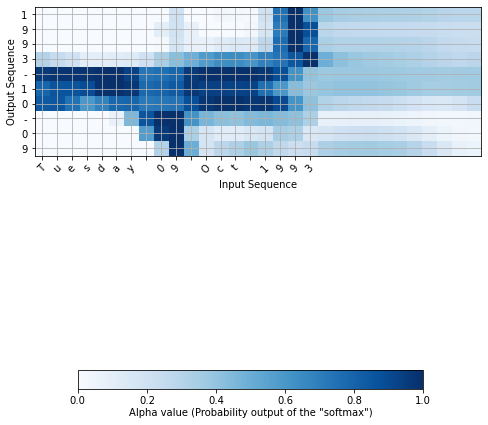

In [26]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

En el gráfico generado puedes observar los valores de los pesos de atención para cada carácter de la salida predicha. Examine este gráfico y compruebe que los lugares en los que la red presta atención tienen sentido para usted.

En la aplicación de traducción de fechas, observará que la mayor parte del tiempo la atención ayuda a predecir el año, y no tiene mucho impacto en la predicción del día o del mes.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that the places where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and doesn't have much impact on predicting the day or month.

### ¡Felicidades!


Has llegado al final de esta tarea 

#### Esto es lo que debes recordar

- Los modelos de traducción automática pueden utilizarse para mapear de una secuencia a otra. Son útiles no sólo para traducir idiomas humanos (como francés->inglés), sino también para tareas como la traducción de formatos de fecha. 
- Un mecanismo de atención permite a una red centrarse en las partes más relevantes de la entrada al producir una parte específica de la salida. 
- Una red que utiliza un mecanismo de atención puede traducir de entradas de longitud $T_x$ a salidas de longitud $T_y$, donde $T_x$ y $T_y$ pueden ser diferentes. 
- Se pueden visualizar los pesos de atención $\alpha^{\langle t,t' \rangle}$ para ver a qué presta atención la red mientras genera cada salida.

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

### Congratulations!


You have come to the end of this assignment 

#### Here's what you should remember

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

Enhorabuena por haber terminado esta tarea. Ahora es capaz de implementar un modelo de atención y utilizarlo para aprender mapeos complejos de una secuencia a otra. 

<details><summary><font size="2" color="darkblue"><b> Texto Original </b></font></summary>

Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 